In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!apt-get update
!apt-get install -y colmap
!pip install opencv-python open3d

Mounted at /content/drive
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,769 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [62.6 kB]
Get:13 https://ppa.launchpadcontent.net/deadsnakes/p

In [2]:
import os

# Define fresh paths
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2"
VIDEO_DIR = f"{BASE_DIR}/video"
FRAMES_DIR = f"{BASE_DIR}/frames"
PC_DIR = f"{BASE_DIR}/point_cloud"

# Create directories
for d in [VIDEO_DIR, FRAMES_DIR, PC_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"✅ Clean file system created at: {BASE_DIR}")

✅ Clean file system created at: /content/drive/MyDrive/Hackathon_MVP_v2


In [3]:
import cv2
import os

VIDEO_PATH = "/content/drive/MyDrive/Hackathon_MVP_v2/video/Copy of 01_production_masonry.mp4"
FRAMES_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2/frames"

if not os.path.exists(VIDEO_PATH):
    print(f"❌ ERROR: Cannot find video. Check that it is inside {VIDEO_PATH}")
else:
    print("Video found. Extracting first 180 frames...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    fps = round(cap.get(cv2.CAP_PROP_FPS))
    if fps == 0: fps = 30

    count = 0
    saved = 0

    while cap.isOpened() and saved < 180:
        ret, frame = cap.read()
        if not ret: break

        # Save 1 frame per second
        if count % fps == 0:
            cv2.imwrite(os.path.join(FRAMES_DIR, f"frame_{saved:05d}.jpg"), frame)
            saved += 1
        count += 1

    cap.release()
    print(f"✅ Extracted {saved} frames successfully.")

Video found. Extracting first 180 frames...
✅ Extracted 180 frames successfully.


In [4]:
import os
import subprocess

# Block the GUI crash
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# Paths
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2"
IMAGE_DIR = f"{BASE_DIR}/frames"
WORKSPACE_DIR = f"{BASE_DIR}/point_cloud/model"
DB_PATH = f"{WORKSPACE_DIR}/database.db"
OUT_PLY = f"{BASE_DIR}/point_cloud/model_sparse.ply"

os.makedirs(WORKSPACE_DIR, exist_ok=True)
if os.path.exists(DB_PATH): os.remove(DB_PATH)

def run_cmd(cmd):
    print(f"\n--- Running: {cmd[1]} ---")
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in proc.stdout: print(line, end="")
    proc.wait()
    if proc.returncode != 0: raise subprocess.CalledProcessError(proc.returncode, cmd)

print("STARTING COLMAP (CPU MODE)")

# 1. Extract Features (CPU only)
run_cmd(["colmap", "feature_extractor", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--ImageReader.single_camera", "1", "--SiftExtraction.use_gpu", "0"])

# 2. Match Features (CPU only)
run_cmd(["colmap", "sequential_matcher", "--database_path", DB_PATH, "--SequentialMatching.overlap", "10", "--SiftMatching.use_gpu", "0"])

# 3. Map (CPU only)
run_cmd(["colmap", "mapper", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--output_path", WORKSPACE_DIR])

# 4. Export PLY
if os.path.exists(f"{WORKSPACE_DIR}/0"):
    run_cmd(["colmap", "model_converter", "--input_path", f"{WORKSPACE_DIR}/0", "--output_path", OUT_PLY, "--output_type", "PLY"])
    print(f"\n✅ SUCCESS! Model saved to: {OUT_PLY}")
else:
    print("\n❌ ERROR: Mapping failed to produce a model.")

Streaming output truncated to the last 5000 lines.
   8  1.606632e+02    4.71e-02    8.84e+01   6.56e+00   7.15e-01  3.27e+05        1    2.95e-03    2.58e-02
   9  1.606075e+02    5.57e-02    7.40e+01   6.20e+00   8.35e-01  4.68e+05        1    2.85e-03    2.87e-02
  10  1.605676e+02    3.99e-02    1.08e+02   7.45e+00   6.40e-01  4.78e+05        1    2.92e-03    3.16e-02
  11  1.605159e+02    5.17e-02    7.53e+01   6.32e+00   8.46e-01  7.17e+05        1    2.87e-03    3.45e-02
  12  1.604908e+02    2.51e-02    1.11e+02   7.41e+00   5.32e-01  7.17e+05        1    2.84e-03    3.74e-02
  13  1.604505e+02    4.03e-02    6.33e+01   5.70e+00   8.72e-01  1.22e+06        1    2.88e-03    4.03e-02
  14  1.604396e+02    1.09e-02    9.55e+01   6.64e+00   4.01e-01  1.21e+06        1    3.05e-03    4.34e-02
  15  1.604142e+02    2.54e-02    3.73e+01   4.36e+00   9.45e-01  3.62e+06        1    2.91e-03    4.64e-02
  16  1.604157e+02   -1.52e-03    3.73e+01   5.68e+00  -1.57e-01  1.81e+06        1  

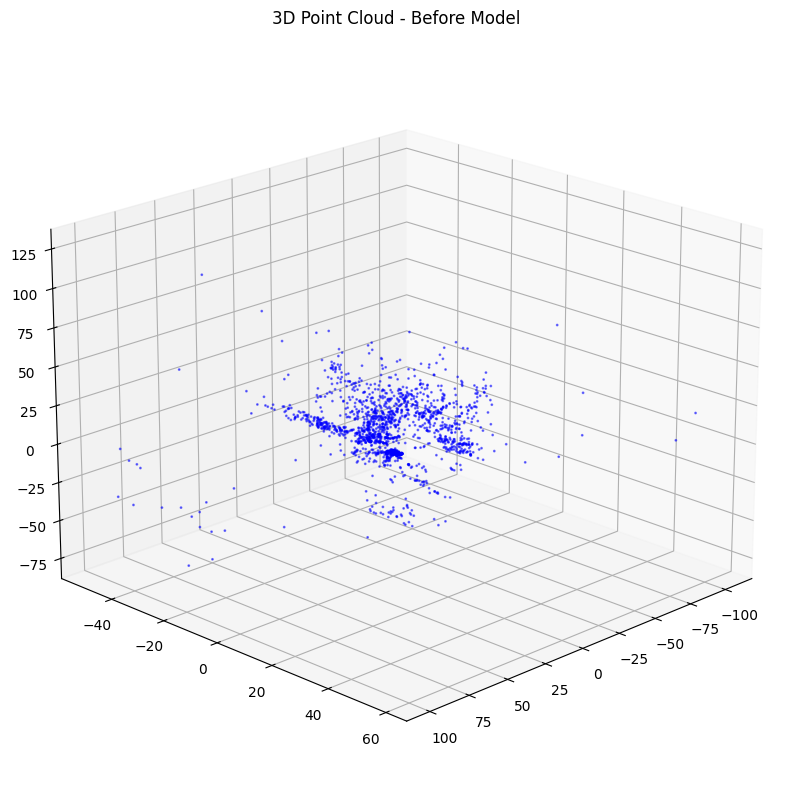

✅ Model contains 8570 points.


In [5]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Path to the model you just created
ply_path = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/model_sparse.ply"

if not os.path.exists(ply_path):
    print(f"❌ ERROR: Could not find the file at {ply_path}")
else:
    # Load the point cloud
    pcd = o3d.io.read_point_cloud(ply_path)

    # If the model is too thin, we can paint it a uniform color to see it better
    # pcd.paint_uniform_color([0.5, 0.5, 0.5])

    # Extract points to plot them in Matplotlib (since we are headless)
    points = np.asarray(pcd.points)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # We only plot a subset of points (every 5th) so it's not too slow
    ax.scatter(points[::5, 0], points[::5, 1], points[::5, 2], s=1, c='blue', alpha=0.5)

    ax.set_title("3D Point Cloud - Before Model")
    ax.view_init(elev=20, azim=45) # You can adjust these angles to rotate the view
    plt.show()

    print(f"✅ Model contains {len(points)} points.")

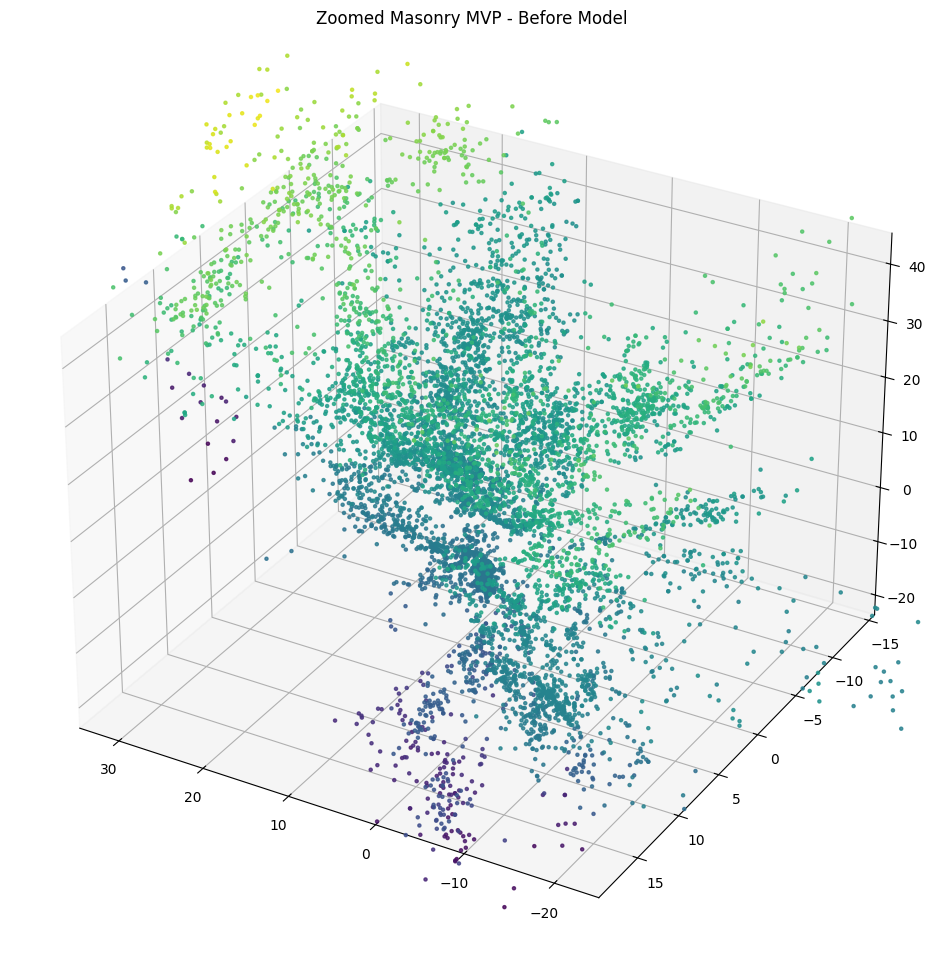

Viewing 8319 cleaned points.


In [6]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

ply_path = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/model_sparse.ply"

if os.path.exists(ply_path):
    pcd = o3d.io.read_point_cloud(ply_path)
    points = np.asarray(pcd.points)

    # Remove statistical outliers (cleans up "floating" dots)
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    pcd_clean = pcd.select_by_index(ind)
    clean_points = np.asarray(pcd_clean.points)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    # s=5 makes the points larger and easier to see
    ax.scatter(clean_points[:, 0], clean_points[:, 1], clean_points[:, 2],
               s=5, c=clean_points[:, 2], cmap='viridis', alpha=0.8)

    # AUTO-ZOOM: Set the limits based on the actual point data
    mean = np.mean(clean_points, axis=0)
    std = np.std(clean_points, axis=0)
    ax.set_xlim(mean[0] - 2*std[0], mean[0] + 2*std[0])
    ax.set_ylim(mean[1] - 2*std[1], mean[1] + 2*std[1])
    ax.set_zlim(mean[2] - 2*std[2], mean[2] + 2*std[2])

    ax.view_init(elev=30, azim=120)
    plt.title("Zoomed Masonry MVP - Before Model")
    plt.show()
    print(f"Viewing {len(clean_points)} cleaned points.")
else:
    print("File not found.")

In [7]:
import cv2
import os

# Paths
VIDEO_PATH = "/content/drive/MyDrive/Hackathon_MVP_v2/video/Copy of 01_production_masonry.mp4"
AFTER_FRAMES_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2/frames_after"
os.makedirs(AFTER_FRAMES_DIR, exist_ok=True)

print("--- EXTRACTING LAST 3 MINUTES ---")
cap = cv2.VideoCapture(VIDEO_PATH)
fps = round(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate the end: 180 seconds (3 mins) at 1 frame per second
three_minutes_in_frames = 180 * fps
start_frame = max(0, total_frames - three_minutes_in_frames)

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
saved = 0
count = 0

while cap.isOpened() and saved < 180:
    ret, frame = cap.read()
    if not ret: break

    if count % fps == 0:
        cv2.imwrite(os.path.join(AFTER_FRAMES_DIR, f"after_frame_{saved:05d}.jpg"), frame)
        saved += 1
    count += 1

cap.release()
print(f"✅ SUCCESS! Extracted {saved} 'After' frames.")

--- EXTRACTING LAST 3 MINUTES ---
✅ SUCCESS! Extracted 180 'After' frames.


In [9]:
import cv2
import os

# New folder for 2fps frames
AFTER_FRAMES_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2/frames_after_2fps"
os.makedirs(AFTER_FRAMES_DIR, exist_ok=True)
VIDEO_PATH = "/content/drive/MyDrive/Hackathon_MVP_v2/video/Copy of 01_production_masonry.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
fps = round(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate last 4 minutes (240 seconds)
four_minutes_in_frames = 240 * fps
start_frame = max(0, total_frames - four_minutes_in_frames)

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
saved = 0
count = 0
frame_interval = fps // 2 # Extract 2 frames every second

print("--- EXTRACTING LAST 4 MINUTES (2 FPS) ---")
while cap.isOpened() and saved < 480: # 240 seconds * 2 fps
    ret, frame = cap.read()
    if not ret: break
    if count % frame_interval == 0:
        cv2.imwrite(os.path.join(AFTER_FRAMES_DIR, f"after_frame_{saved:05d}.jpg"), frame)
        saved += 1
    count += 1

cap.release()
print(f"✅ Done! Extracted {saved} frames.")

--- EXTRACTING LAST 4 MINUTES (2 FPS) ---
✅ Done! Extracted 480 frames.


In [8]:
import os
import subprocess

# Paths
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2"
IMAGE_DIR = f"{BASE_DIR}/frames_after"
WORKSPACE_DIR = f"{BASE_DIR}/point_cloud/model_after"
DB_PATH = f"{WORKSPACE_DIR}/database_after.db"
OUT_PLY = f"{BASE_DIR}/point_cloud/after_model_sparse.ply"

os.makedirs(WORKSPACE_DIR, exist_ok=True)
if os.path.exists(DB_PATH): os.remove(DB_PATH)

def run_cmd(cmd):
    print(f"\n--- Running: {cmd[1]} ---")
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in proc.stdout: print(line, end="")
    proc.wait()
    if proc.returncode != 0: raise subprocess.CalledProcessError(proc.returncode, cmd)

print("--- STARTING 'AFTER' RECONSTRUCTION ---")

# 1. Feature Extraction
run_cmd(["colmap", "feature_extractor", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--ImageReader.single_camera", "1", "--SiftExtraction.use_gpu", "0"])

# 2. Sequential Matching
run_cmd(["colmap", "sequential_matcher", "--database_path", DB_PATH, "--SequentialMatching.overlap", "10", "--SiftMatching.use_gpu", "0"])

# 3. Mapper
run_cmd(["colmap", "mapper", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--output_path", WORKSPACE_DIR])

# 4. Export
if os.path.exists(f"{WORKSPACE_DIR}/0"):
    run_cmd(["colmap", "model_converter", "--input_path", f"{WORKSPACE_DIR}/0", "--output_path", OUT_PLY, "--output_type", "PLY"])
    print(f"\n✅ PROJECT COMPLETE! 'After' model saved to: {OUT_PLY}")
else:
    print("\n❌ Mapping failed. Ensure the camera move was steady.")

Streaming output truncated to the last 5000 lines.

Registering image #139 (3)

  => Image sees 39 / 1026 points
  => Could not register, trying another image.

Registering image #140 (3)

  => Image sees 38 / 1111 points
  => Could not register, trying another image.

Registering image #152 (3)

  => Image sees 34 / 534 points
  => Could not register, trying another image.

Registering image #129 (3)

  => Image sees 31 / 706 points
  => Could not register, trying another image.

Registering image #149 (3)

  => Image sees 36 / 604 points
  => Could not register, trying another image.

Registering image #143 (3)

  => Image sees 31 / 485 points
  => Could not register, trying another image.

Registering image #141 (3)

  => Image sees 30 / 727 points
  => Could not register, trying another image.

Registering image #147 (3)

  => Image sees 32 / 577 points
  => Could not register, trying another image.

Registering image #148 (3)

  => Image sees 31 / 655 points
  => Could not registe

In [10]:
import os
import subprocess

# Paths
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2"
IMAGE_DIR = f"{BASE_DIR}/frames_after_2fps"
WORKSPACE_DIR = f"{BASE_DIR}/point_cloud/model_after_dense"
DB_PATH = f"{WORKSPACE_DIR}/database_after_2fps.db"
OUT_PLY = f"{BASE_DIR}/point_cloud/after_model_sparse.ply"

os.makedirs(WORKSPACE_DIR, exist_ok=True)
if os.path.exists(DB_PATH): os.remove(DB_PATH)

def run_cmd(cmd):
    print(f"\n--- Running: {cmd[1]} ---")
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in proc.stdout: print(line, end="")
    proc.wait()
    if proc.returncode != 0: raise subprocess.CalledProcessError(proc.returncode, cmd)

print("--- STARTING 2FPS 'AFTER' RECONSTRUCTION ---")

# 1. Feature Extraction
run_cmd(["colmap", "feature_extractor", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--ImageReader.single_camera", "1", "--SiftExtraction.use_gpu", "0"])

# 2. Sequential Matching
run_cmd(["colmap", "sequential_matcher", "--database_path", DB_PATH, "--SequentialMatching.overlap", "10", "--SiftMatching.use_gpu", "0"])

# 3. Mapper
run_cmd(["colmap", "mapper", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--output_path", WORKSPACE_DIR])

# 4. Export PLY
if os.path.exists(f"{WORKSPACE_DIR}/0"):
    run_cmd(["colmap", "model_converter", "--input_path", f"{WORKSPACE_DIR}/0", "--output_path", OUT_PLY, "--output_type", "PLY"])
    print(f"\n✅ SUCCESS! 'After' model saved to: {OUT_PLY}")
else:
    print("\n❌ Mapping failed again. We might need a different video segment.")

Streaming output truncated to the last 5000 lines.
  => Merged observations: 0
  => Filtered observations: 3
  => Changed observations: 0.002190

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.875118e+02    0.00e+00    5.09e+02   0.00e+00   0.00e+00  1.00e+04        0    2.20e-03    5.43e-03
   1  8.871497e+02    3.62e-01    1.31e+01   5.33e+00   9.88e-01  3.00e+04        1    5.53e-03    1.10e-02
   2  8.871258e+02    2.38e-02    3.17e+00   6.18e+00   1.13e+00  9.00e+04        1    4.59e-03    1.56e-02
   3  8.871125e+02    1.33e-02    1.82e+00   6.97e+00   1.14e+00  2.70e+05        1    4.51e-03    2.02e-02
   4  8.871056e+02    6.94e-03    4.94e+00   7.16e+00   1.08e+00  8.10e+05        1    4.28e-03    2.45e-02
   5  8.871038e+02    1.83e-03    1.95e+00   3.81e+00   1.20e+00  2.43e+06        1    4.24e-03    2.88e-02
   6  8.871035e+02    3.02e-04    1.84e+00   1.51e+00   1.13e+00  7.29e+

In [11]:
import os
import open3d as o3d

ply_path = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/after_model_sparse.ply"

if os.path.exists(ply_path):
    size = os.path.getsize(ply_path) / 1024  # Size in KB
    print(f"File Size: {size:.2f} KB")

    try:
        pcd = o3d.io.read_point_cloud(ply_path)
        print(f"Number of points in 'After' model: {len(pcd.points)}")

        if len(pcd.points) == 0:
            print("❌ The model is empty because the mapper couldn't find matching features.")
    except:
        print("❌ Could not read the file. It might be corrupted or empty.")
else:
    print("❌ File does not exist.")

File Size: 7.51 KB
Number of points in 'After' model: 501


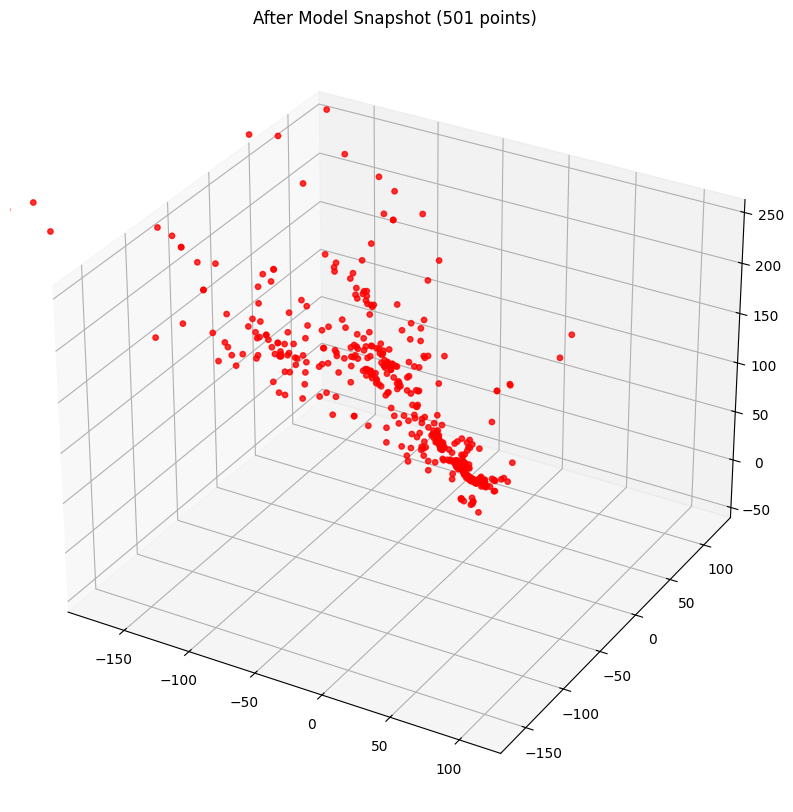

In [12]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

ply_path = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/after_model_sparse.ply"

if os.path.exists(ply_path):
    pcd = o3d.io.read_point_cloud(ply_path)
    points = np.asarray(pcd.points)

    if len(points) > 0:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # s=15 makes these few points much chunkier and visible
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=15, c='red', alpha=0.8)

        # Auto-scale
        mean = np.mean(points, axis=0)
        max_range = np.array([points[:,0].max()-points[:,0].min(),
                             points[:,1].max()-points[:,1].min(),
                             points[:,2].max()-points[:,2].min()]).max() / 2.0

        ax.set_xlim(mean[0] - max_range, mean[0] + max_range)
        ax.set_ylim(mean[1] - max_range, mean[1] + max_range)
        ax.set_zlim(mean[2] - max_range, mean[2] + max_range)

        plt.title(f"After Model Snapshot ({len(points)} points)")
        plt.show()
    else:
        print("No points to display.")

In [13]:
import cv2
import os

# New folder for this specific segment
MID_STAGE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2/frames_5to9"
os.makedirs(MID_STAGE_DIR, exist_ok=True)
VIDEO_PATH = "/content/drive/MyDrive/Hackathon_MVP_v2/video/Copy of 01_production_masonry.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
fps = round(cap.get(cv2.CAP_PROP_FPS))

# Start at 5 minutes (300 seconds), end at 9 minutes (540 seconds)
start_frame = 300 * fps
end_frame = 540 * fps

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
saved = 0
count = 0

print("--- EXTRACTING MINUTES 5 THROUGH 9 (1 FPS) ---")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or (start_frame + count) > end_frame:
        break

    if count % fps == 0:
        cv2.imwrite(os.path.join(MID_STAGE_DIR, f"mid_frame_{saved:05d}.jpg"), frame)
        saved += 1
    count += 1

cap.release()
print(f"✅ SUCCESS! Extracted {saved} frames into: {MID_STAGE_DIR}")

--- EXTRACTING MINUTES 5 THROUGH 9 (1 FPS) ---
✅ SUCCESS! Extracted 241 frames into: /content/drive/MyDrive/Hackathon_MVP_v2/frames_5to9


In [14]:
import os
import subprocess

# Paths
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v2"
IMAGE_DIR = f"{BASE_DIR}/frames_5to9"
WORKSPACE_DIR = f"{BASE_DIR}/point_cloud/model_5to9"
DB_PATH = f"{WORKSPACE_DIR}/database_5to9.db"
OUT_PLY = f"{BASE_DIR}/point_cloud/model_5to9_sparse.ply"

os.makedirs(WORKSPACE_DIR, exist_ok=True)
if os.path.exists(DB_PATH): os.remove(DB_PATH)

def run_cmd(cmd):
    print(f"\n--- Running: {cmd[1]} ---")
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in proc.stdout: print(line, end="")
    proc.wait()
    if proc.returncode != 0: raise subprocess.CalledProcessError(proc.returncode, cmd)

print("--- STARTING RECONSTRUCTION (MINUTES 5-9) ---")

# 1. Feature Extraction
run_cmd(["colmap", "feature_extractor", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--ImageReader.single_camera", "1", "--SiftExtraction.use_gpu", "0"])

# 2. Sequential Matching
run_cmd(["colmap", "sequential_matcher", "--database_path", DB_PATH, "--SequentialMatching.overlap", "10", "--SiftMatching.use_gpu", "0"])

# 3. Mapper
run_cmd(["colmap", "mapper", "--database_path", DB_PATH, "--image_path", IMAGE_DIR, "--output_path", WORKSPACE_DIR])

# 4. Export PLY
if os.path.exists(f"{WORKSPACE_DIR}/0"):
    run_cmd(["colmap", "model_converter", "--input_path", f"{WORKSPACE_DIR}/0", "--output_path", OUT_PLY, "--output_type", "PLY"])
    print(f"\n✅ SUCCESS! Middle-stage model saved to: {OUT_PLY}")
else:
    print("\n❌ Mapping failed. If this doesn't work, we'll try a 30-second burst instead.")

Streaming output truncated to the last 5000 lines.
  => Completed observations: 0
  => Merged observations: 0
  => Filtered observations: 1
  => Changed observations: 0.000239
  => Filtered images: 0

Registering image #156 (25)

  => Image sees 67 / 1049 points

Pose refinement report
----------------------
    Residuals : 126
   Parameters : 6
   Iterations : 14
         Time : 0.0018909 [s]
 Initial cost : 0.749006 [px]
   Final cost : 0.634037 [px]
  Termination : Convergence

  => Continued observations: 63
  => Added observations: 97

Bundle adjustment report
------------------------
    Residuals : 1994
   Parameters : 596
   Iterations : 24
         Time : 0.052398 [s]
 Initial cost : 0.732019 [px]
   Final cost : 0.695699 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 9
  => Filtered observations: 44
  => Changed observations: 0.044575

Bundle adjustment report
------------------------
    Residuals : 2116
   Parameters : 548
   Iter

Total points found: 2492


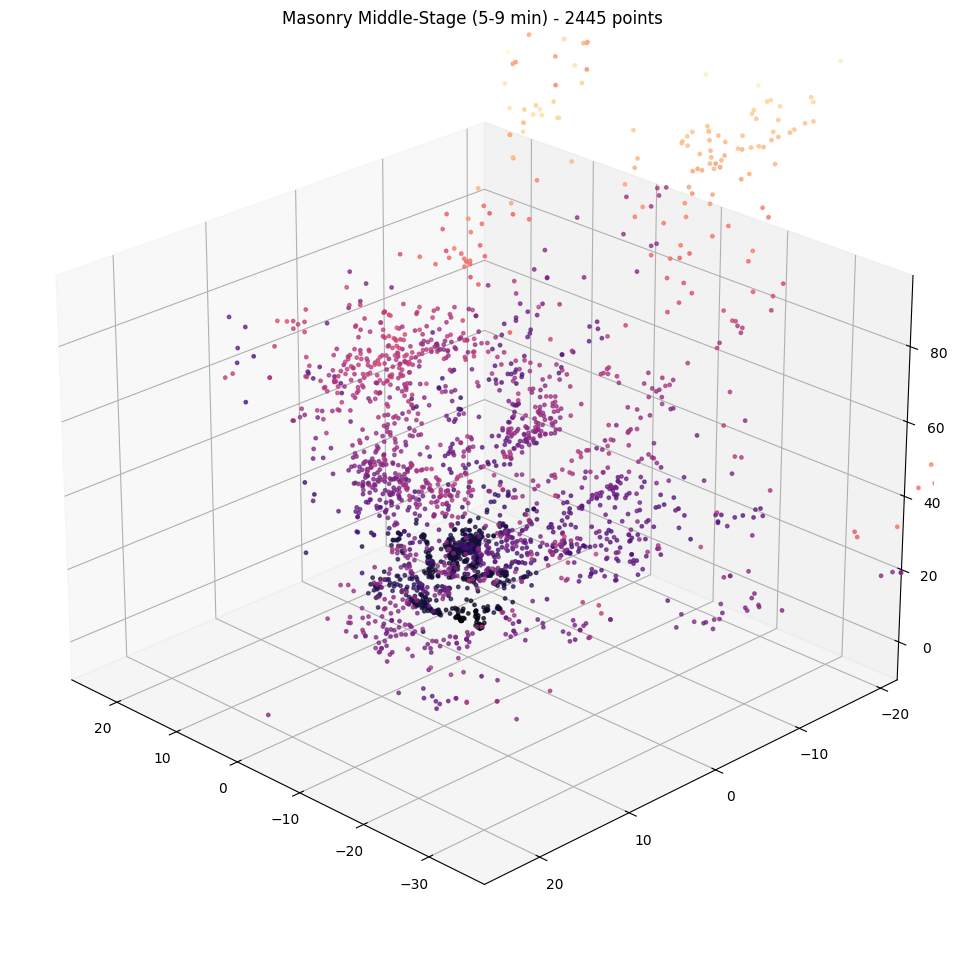

In [15]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os

ply_path = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/model_5to9_sparse.ply"

if os.path.exists(ply_path):
    pcd = o3d.io.read_point_cloud(ply_path)
    points = np.asarray(pcd.points)
    print(f"Total points found: {len(points)}")

    if len(points) > 50: # Ensure we actually have a model to look at
        # 1. Clean up noise (outliers)
        cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
        pcd_clean = pcd.select_by_index(ind)
        clean_points = np.asarray(pcd_clean.points)

        # 2. Setup Plot
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')

        # 3. Plot with large points (s=6) and color mapping for depth
        scatter = ax.scatter(clean_points[:, 0], clean_points[:, 1], clean_points[:, 2],
                             s=6, c=clean_points[:, 2], cmap='magma', alpha=0.7)

        # 4. Auto-Zoom based on data distribution
        mean = np.mean(clean_points, axis=0)
        std = np.std(clean_points, axis=0)
        ax.set_xlim(mean[0] - 2*std[0], mean[0] + 2*std[0])
        ax.set_ylim(mean[1] - 2*std[1], mean[1] + 2*std[1])
        ax.set_zlim(mean[2] - 2*std[2], mean[2] + 2*std[2])

        ax.view_init(elev=25, azim=135)
        plt.title(f"Masonry Middle-Stage (5-9 min) - {len(clean_points)} points")
        plt.show()
    else:
        print(f"❌ Model too small to visualize ({len(points)} points). The mapper likely failed to link frames.")
else:
    print("❌ File not found. Check if the COLMAP script finished successfully.")

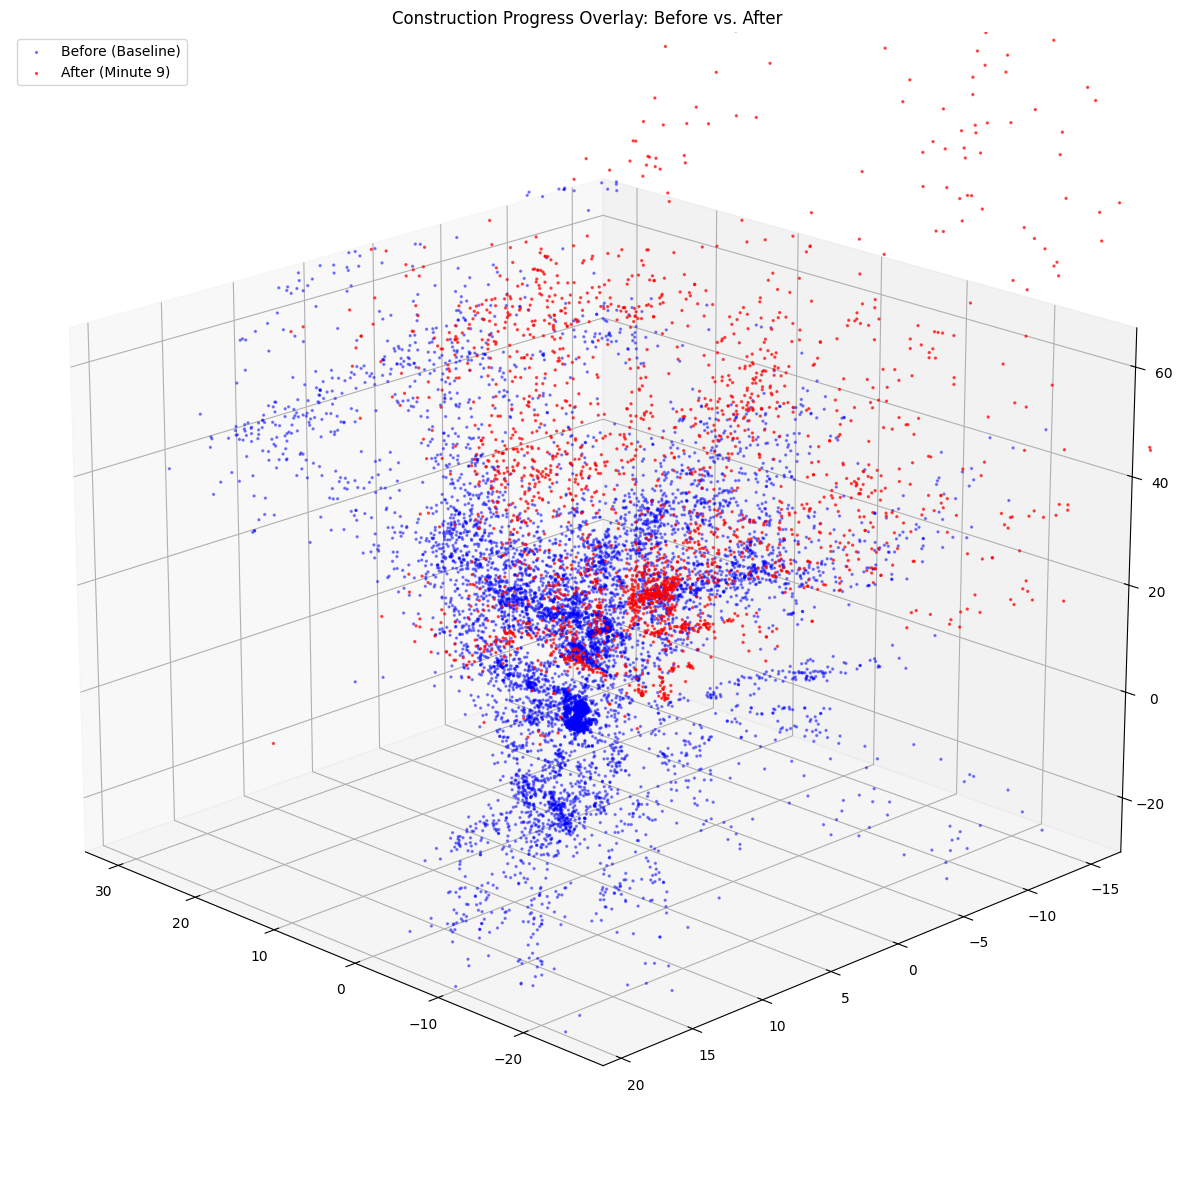

In [16]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Paths
path_before = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/model_sparse.ply"
path_after = "/content/drive/MyDrive/Hackathon_MVP_v2/point_cloud/model_5to9_sparse.ply"

def load_and_clean(path):
    pcd = o3d.io.read_point_cloud(path)
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    return pcd.select_by_index(ind)

if not os.path.exists(path_before) or not os.path.exists(path_after):
    print("❌ One of the models is missing!")
else:
    pcd_before = load_and_clean(path_before)
    pcd_after = load_and_clean(path_after)

    # Convert to numpy for plotting
    pts_before = np.asarray(pcd_before.points)
    pts_after = np.asarray(pcd_after.points)

    # --- MANUAL ALIGNMENT (Nudge these if they don't line up) ---
    # Example: pts_after += [x_nudge, y_nudge, z_nudge]
    pts_after += [0, 0, 0]

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Before (Blue)
    ax.scatter(pts_before[:, 0], pts_before[:, 1], pts_before[:, 2],
               s=2, c='blue', label='Before (Baseline)', alpha=0.4)

    # Plot After (Red)
    ax.scatter(pts_after[:, 0], pts_after[:, 1], pts_after[:, 2],
               s=2, c='red', label='After (Minute 9)', alpha=0.6)

    # Standardize the view
    all_pts = np.vstack((pts_before, pts_after))
    mean = np.mean(all_pts, axis=0)
    std = np.std(all_pts, axis=0)
    ax.set_xlim(mean[0] - 2*std[0], mean[0] + 2*std[0])
    ax.set_ylim(mean[1] - 2*std[1], mean[1] + 2*std[1])
    ax.set_zlim(mean[2] - 2*std[2], mean[2] + 2*std[2])

    ax.view_init(elev=20, azim=135)
    plt.legend()
    plt.title("Construction Progress Overlay: Before vs. After")
    plt.show()